#notebooks.qcbm_benchmark_1d

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.optimize import minimize

In [2]:
import os
os.chdir('..')

In [3]:
from config import *
from utilities.qcbm import ArbitraryRotation, CNOTEntangler, BlockQueue, QCBM
from utilities.kernels import RBFMMD2

In [4]:
def get_nn_pairs(num_bit):
    '''get nearest neighbor pairs (CNOTs are applied to these pairs).'''
    res = []
    for inth in range(2):
        for i in range(inth, num_bit, 2):
            res = res + [(i, i_ % num_bit) for i_ in range(i + 1, i + 2)]
    return res

def get_circuit(num_bit, depth, pairs):
    '''Get the qcbm circuit with given number of qubits, depth and CNOT pairs'''
    blocks = []
    # build circuit
    for idepth in range(depth+1):
        blocks.append(ArbitraryRotation(num_bit))
        if idepth!=depth:
            blocks.append(CNOTEntangler(num_bit, pairs))
    # set leading and trailing Rz to disabled
    blocks[0].mask[::3] = False
    blocks[-1].mask[2::3] = False
    return BlockQueue(blocks)

In [5]:
def train(bm, theta_list, method, max_iter=1000, step_rate=0.1):
    '''
    train a Born Machine.

    Args:
        bm (QCBM): quantum circuit born machine training strategy.
        theta_list (1darray): initial parameters.
        method ('COBYLA'): optimization method
        max_iter (int): maximum allowed number of iterations.
        step_rate (float): learning rate for Adam optimizer.

    Returns:
        (float, 1darray): final loss and parameters.
    '''
    step = [0]
    def callback(x, *args, **kwargs):
        step[0] += 1
        print('step = %d, loss = %s'%(step[0], bm.mmd_loss(x)))

    theta_list = np.array(theta_list)
    res = minimize(bm.mmd_loss, x0=theta_list, method=method, tol=1e-12,
                   options={'maxiter': max_iter, 'disp': 0},callback=callback,)
    return res.fun, res.x

In [6]:
alpha = 2
beta_ = 2
m = 4
depth = 1
a = 0
b = 1

In [7]:
p_i_set = beta.pdf(np.linspace(a, b, 2**m), alpha, beta_)
p_i_set /= p_i_set.sum()

In [8]:
pairs = get_nn_pairs(m)
circuit = get_circuit(m, depth, pairs)
mmd = RBFMMD2(sigma_list=[1,2], basis=np.arange(2**m))
bm = QCBM(circuit, mmd, p_i_set, batch_size=None)

In [9]:
theta_list = np.random.random(bm.circuit.num_param)*2*np.pi
loss, theta_list = train(bm, theta_list, 'COBYLA', max_iter=99)
pl = bm.pdf(theta_list)

step = 1, loss = 0.6836887529911742
step = 2, loss = 0.6708056889573536
step = 3, loss = 0.4027501797122242
step = 4, loss = 0.37368368297447824
step = 5, loss = 0.255342910306281
step = 6, loss = 0.23415688834041123
step = 7, loss = 0.16977218983573378
step = 8, loss = 0.1776055830611478
step = 9, loss = 0.18405868900530734
step = 10, loss = 0.1956910717249295
step = 11, loss = 0.20307226684892926
step = 12, loss = 0.20534670896901341
step = 13, loss = 0.20169974781117872
step = 14, loss = 0.2490480239862641
step = 15, loss = 0.16997648802977758
step = 16, loss = 0.13838237127595074
step = 17, loss = 0.12169481365926749
step = 18, loss = 0.11413706111310348
step = 19, loss = 0.08007390634882172
step = 20, loss = 0.04944131409159455
step = 21, loss = 0.05871745567981432
step = 22, loss = 0.07737619863026148
step = 23, loss = 0.049971953722068044
step = 24, loss = 0.053721781031455404
step = 25, loss = 0.034649491656466504
step = 26, loss = 0.02062825504619423
step = 27, loss = 0.082678

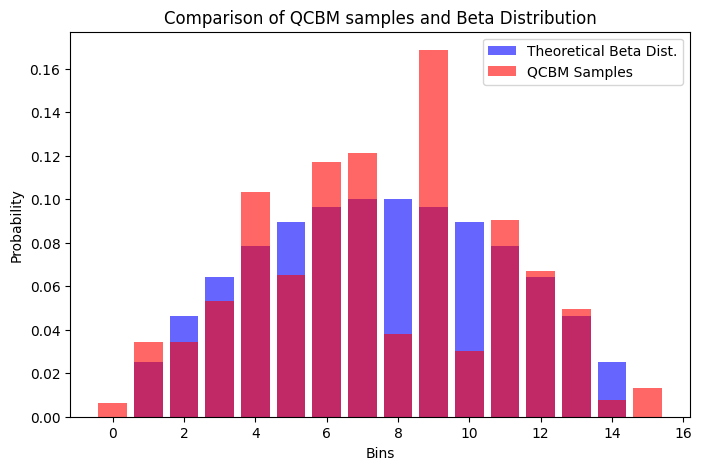

In [10]:
plt.figure(figsize=(8, 5))
plt.bar(range(len(p_i_set)), p_i_set, alpha=0.6, label='Theoretical Beta Dist.', color='blue')
plt.bar(range(len(pl)), pl, alpha=0.6, label='QCBM Samples', color='red')
plt.xlabel("Bins")
plt.ylabel("Probability")
plt.legend()
plt.title("Comparison of QCBM samples and Beta Distribution")
plt.show()